In [1]:
using PyPlot
using Random

# Illustration in 2d (SGD on expected square loss)

Parameters of the teacher neural network

In [33]:
Random.seed!(3) # looking for a case where the global minimizers are aligned with the teacher (this is not systematic)
d = 2
m_tc = 4
A_tc = rand([-1.0,1.0],m_tc) # random init. output weights
B_tc = randn(d, m_tc)
B_tc = B_tc ./ sqrt.(sum(B_tc.^2, dims=1));

Train the student neural network

In [91]:
Random.seed!(8) # looking for a example where m=5 does not converge globally
niter = 200000 
lr = 0.002 # learning rate (small to approximate gradient flow)
bs = 100 # batch size
m = 5 # number of neurons in the network that we train
A = randn(m) 
A = sign.(A) / m # random init. output weights in {-1,+1}
B = randn(d,m)
B = B ./ sqrt.(sum(B.^2, dims=1)) # random init input weights on the unit sphere
As = zeros(m, niter)
Bs = zeros(d, m, niter)

for t = 1:niter # gradient descent
    As[:,t] = A
    Bs[:,:,t] = B
    X = randn(d,bs) # Gaussian input batch
    Y = A_tc' * max.(B_tc'*X, 0.0) # teacher output
    H = max.(B'*X, 0.0) # activations
    G = A' * H - Y # gradient at output
    GA = H * G'/bs # gradient for the output weights
    A  = A .- (1/m) * lr * GA[:]
    GB = A .* float.(H .> 0) * (X .* G)' # gradient for the input weights
    B  = B .- m * lr * GB'
end

Plot the dynamics

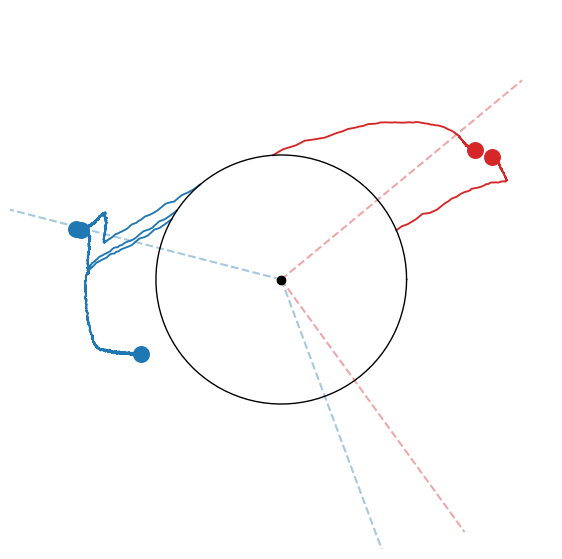

In [92]:
figure(figsize=[7,7])
sc = 2.5*tanh(1/2)
for j=1:m_tc
    if A_tc[j]<0
        plot([0,sc*B_tc[1,j]],[0,sc*B_tc[2,j]],color="C0","--",alpha=0.4)
    else
        plot([0,sc*B_tc[1,j]],[0,sc*B_tc[2,j]],color="C3","--",alpha=0.4)
    end
end

Ws = reshape(abs.(As),1,m,niter) .* Bs * m;

Rs = sqrt.(sum(Ws.^2, dims=1))
Ts = Ws ./ Rs # polar coordinates
sc = 2
for j=1:m
    if As[j,1]<0
        plot(Ts[1,j,:] .* tanh.(Rs[1,j,:]./sc),Ts[2,j,:].* tanh.(Rs[1,j,:]./sc),"C0",lw=3/sqrt(m))
        plot(Ts[1,j,end].* tanh.(Rs[1,j,end]./sc),Ts[2,j,end].* tanh.(Rs[1,j,end]./sc),"oC0",ms=25/sqrt(m))
    else
        plot(Ts[1,j,:].* tanh.(Rs[1,j,:]./sc),Ts[2,j,:].* tanh.(Rs[1,j,:]./sc),"C3",lw=3/sqrt(m))
        plot(Ts[1,j,end].* tanh.(Rs[1,j,end]./sc),Ts[2,j,end].* tanh.(Rs[1,j,end]./sc),"oC3",ms=25/sqrt(m))
    end
end

axis([-1,1,-1,1]);
plot(cos.(range(0,2π,length=100))*tanh(1/sc),sin.(range(0,2π,length=100))*tanh(1/sc),"k",label="unit circle",lw=1)
plot(0,0,"ok")
axis("off")
savefig("ts2d-tanh-m5.png",bbox_inches="tight",dpi=200)

# Success rate in higher dimension (SGD on expected square loss) 

In [337]:
nrep = 30 # number of random repetitions
ms = 1:30 # width of student neural nets to try
d = 20    # ambiant dimension
tab = zeros(length(ms),nrep); # to store the results

In [338]:
for i=1:nrep
    # teacher parameters
    m_tc = 10
    A_tc = rand([-1.0,1.0],m_tc) # random init. output weights
    B_tc = randn(d, m_tc)
    B_tc = B_tc ./ sqrt.(sum(B_tc.^2, dims=1)) 
    niter = 10000
    lr = 0.005
    bs = 100

    for j=1:length(ms)
        m = ms[j]
        A = randn(m)
        A = sign.(A) / m # random init. output weights
        B = randn(d,m)
        B = B ./ sqrt.(sum(B.^2, dims=1)) # random init input weights
        As = zeros(m, niter)
        Bs = zeros(d, m, niter)

        for t = 1:niter
            As[:,t] = A
            Bs[:,:,t] = B
            X = randn(d,bs) # Gaussian input batch
            Y = A_tc' * max.(B_tc'*X, 0.0) # teacher output
            H = max.(B'*X, 0.0) # activations
            G = A' * H - Y # gradient at output
            GA = H * G'/bs
            A  = A .- (1/m) * lr * GA[:]
            GB = A .* float.(H .> 0) * (X .* G)'
            B  = B .- m * lr * GB'
        end
        
        n_test = 1000
        X = randn(d,n_test) # Gaussian input batch
        Y = A_tc' * max.(B_tc'*X, 0.0) # teacher output
        H = max.(B'*X, 0.0) # activations
        R = (1/2)*sum( (A' * H - Y).^2)/n_test
        tab[j,i] = R
    end
    
end

Plot the final square errors

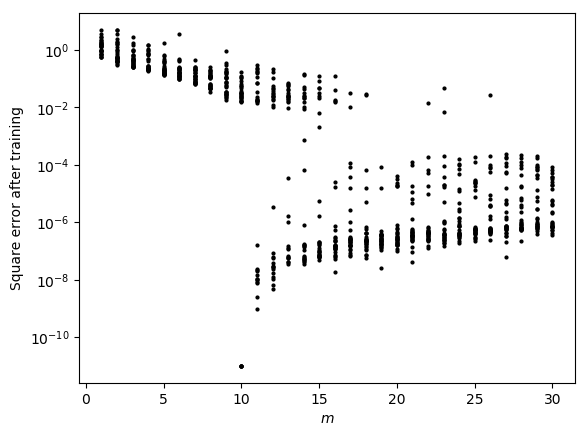

In [339]:
semilogy(1:30, tab .+ 1e-11, ".k", ms=4);
xlabel(L"m")
ylabel("Square error after training")
#savefig("final-error-d20.png")

Plot the success rates

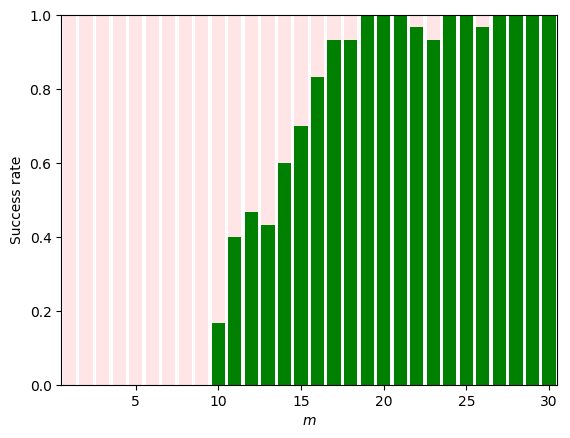

In [340]:
#plot(1:30,1 .- sum( tab .> 1e-3, dims =2)/30,"+k")
bar(1:30,ones(30),color="r",alpha=0.1)
bar(1:30,1 .- sum( tab .> 1e-3, dims =2)[:]/30,color="g")
xlabel(L"m")
ylabel("Success rate")
axis([0.5,30.5,0,1])
#savefig("success-rate-d20.png")